In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt

os.chdir("..")
from assistive_arm.utils.data_preprocessing import prepare_mocap_data, prepare_opencap_data, prepare_mocap_force_data, read_headers, export_filtered_force

## Read data

In [4]:
haedo_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Masterarbeit Harvard/Thesis/Subject data/haedo_data")
project_moco_data = Path("/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/")

# Set directories
opencap_data = haedo_data / "opencap_data"
mocap_data = haedo_data / "mocap_data"
opencap_markers = opencap_data / "MarkerData"

# Read force data trial 1
mocap_force_trial_1_right = pd.read_csv(
    mocap_data / "sit_stand0002_f_20.tsv", 
    delimiter="\t", 
    skiprows=26, 
    names=["ground_force_r_vx", "ground_force_r_vy", "ground_force_r_vz", "ground_force_r_px", "ground_force_r_py", "ground_force_r_pz", "ground_torque_r_x", "ground_torque_r_y", "ground_torque_r_z", "nan"])
mocap_force_trial_1_left = pd.read_csv(
    mocap_data / "sit_stand0002_f_21.tsv", 
    delimiter="\t",
    skiprows=26, 
    names=["ground_force_l_vx", "ground_force_l_vy", "ground_force_l_vz", "ground_force_l_px", "ground_force_l_py", "ground_force_l_pz", "ground_torque_l_x", "ground_torque_l_y", "ground_torque_l_z", "nan"])

# Read mocap marker data
mocap_marker_trial_1 = pd.read_csv(mocap_data / "sit_stand0002.tsv", delimiter="\t", skiprows=11, names=["X", "Y", "Z"])

# Read opencap marker data
headers = read_headers(opencap_markers / "sit_stand_2_w_grf.trc", 3)
            
opencap_marker_trial_1 = pd.read_csv(opencap_markers / "sit_stand_2_w_grf.trc", delimiter="\t", skiprows=3).tail(-1)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Masterarbeit Harvard/Thesis/Subject data/haedo_data/mocap_data/sit_stand0002_f_20.tsv'

## Process data

In [11]:
# Prepare mocap data
mocap_marker_trial_1 = prepare_mocap_data(mocap_marker_trial_1)

# Prepare opencap data
opencap_marker_trial_1 = prepare_opencap_data(opencap_marker_trial_1)

# Prepare and merge force data
mocap_force_trial_1 = prepare_mocap_force_data(mocap_force_trial_1_right, mocap_force_trial_1_left)

In [12]:
def xcorr_and_shift(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, int]:
    """ Cross-correlate two signals and return the lag

    Args:
        x (np.ndarray): first signal
        y (np.ndarray): second signal

    Returns:
        Tuple[np.ndarray, int]: tuple containing the cross-correlation and the lag
    """
    # Pad the shorter signal with NaN
    size_diff = len(x) - len(y)

    if size_diff > 0:
        y = np.pad(y, (0, size_diff), mode='constant', constant_values=np.nan)
    elif size_diff < 0:
        x = np.pad(x, (0, -size_diff), mode='constant', constant_values=np.nan)

    # Compute cross-correlation and lag
    correlation = np.correlate(x, y, 'full')
    lag = round((np.argmax(correlation) - len(x) + 1)/4)
    # Shift the 'y' signal based on the calculated lag
    # y_shifted = np.roll(y, -lag)

    return correlation, lag

def sync_mocap_with_opencap(marker_data: pd.DataFrame, force_data: pd.DataFrame, opencap_data: pd.DataFrame) -> pd.DataFrame:
    # Cut the mocap data such that it perfectly overlaps with opencap

    _, lag = xcorr_and_shift(marker_data.X, opencap_data["LKnee"].X)

    # Shift the data by lag
    marker_data = marker_data.iloc[-lag:-lag + opencap_data.shape[0]].reset_index(drop=True)
    force_data = force_data.iloc[-lag*10:-lag*10 + opencap_data.shape[0]*10].reset_index(drop=True)
    
    force_data["time"] = force_data["time"] - force_data["time"][0]
    marker_data["timestamp"] = marker_data["timestamp"] - marker_data["timestamp"][0]
    
    opencap_data = opencap_data.reset_index(drop=True)

    return marker_data, force_data, opencap_data

In [13]:
mocap_marker_trial_1, mocap_force_trial_1, opencap_marker_trial_1 = sync_mocap_with_opencap(marker_data=mocap_marker_trial_1, force_data=mocap_force_trial_1, opencap_data=opencap_marker_trial_1)

In [14]:
export_filtered_force(mocap_force_trial_1, project_moco_data / "forces" / "sit_stand0002_filtered.mot")

In [24]:
mocap_force_trial_1.ground_force_r_px.min()

-73.701096

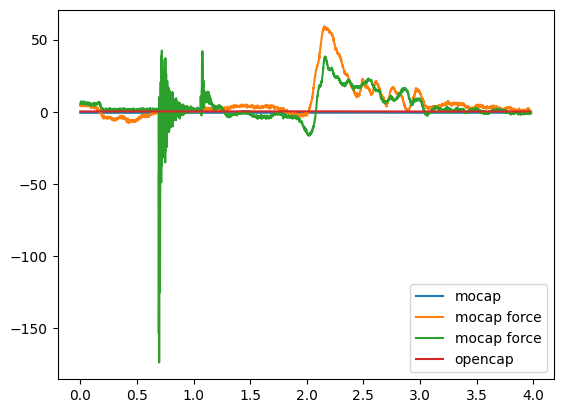

In [ ]:
plt.plot(mocap_marker_trial_1.timestamp, mocap_marker_trial_1.X, label="mocap")
plt.plot(mocap_force_trial_1.time, mocap_force_trial_1.ground_force_r_vx, label="mocap force")
plt.plot(mocap_force_trial_1.time, mocap_force_trial_1.ground_force_l_vx, label="mocap force")
plt.plot(opencap_marker_trial_1.Time.t, opencap_marker_trial_1["LKnee"].X, label="opencap")
plt.legend()

In [ ]:
fig, axs = plt.subplots(3, sharex="row", figsize=(20, 10))

# Plot X data
axs[0].plot(opencap_marker_trial_1["Time"].t, opencap_marker_trial_1["LKnee"].X, label="LKnee X (opencap)")
axs[0].plot(mocap_marker_trial_1.time, mocap_marker_trial_1.X, label="LKnee X (mocap)")
#axs[0].plot(mocap_force_trial_1_right.time, mocap_force_trial_1_right.FPx, label="LKnee X (mocap force)")
axs[0].legend()

# Plot Y data
axs[1].plot(opencap_marker_trial_1["Time"].t, opencap_marker_trial_1["LKnee"].Y, label="LKnee Y (opencap)")
axs[1].plot(mocap_marker_trial_1.time, mocap_marker_trial_1.Y, label="LKnee Y (mocap)")
#axs[1].plot(mocap_force_trial_1_right.timestamp, mocap_force_trial_1_right.FPy, label="LKnee Y (mocap force)")
axs[1].legend()

# Plot Z data
axs[2].plot(opencap_marker_trial_1["Time"].t, opencap_marker_trial_1["LKnee"].Z, label="LKnee Z (opencap)")
axs[2].plot(mocap_marker_trial_1.time, mocap_marker_trial_1.Z, label="LKnee Z (mocap)")
#axs[2].plot(mocap_force_trial_1_right.time, mocap_force_trial_1_right.FPz, label="LKnee Z (mocap force)")
axs[2].legend()

axs[0].autoscale(axis='y', tight=True)
axs[1].autoscale(axis='y', tight=True)
axs[2].autoscale(axis='y', tight=True)

# Display the plot
plt.show()